# TensorFlow Decision Forests - Train your favorite tree-based models using Keras

## Setup

In [1]:
!pip install tensorflow==2.5.1

In [2]:
!pip install tensorflow_decision_forests

In [3]:
!pip install wurlitzer

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

In [5]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.1.8


## Data

In [6]:
cols_to_keep = ["english_name", "gen", "primary_type", "secondary_type",
                "hp", "attack", "defense", "sp_attack", 
                "sp_defense", "speed", "is_legendary", "is_sublegendary", "is_mythical"]

url = "https://raw.githubusercontent.com/erykml/medium_articles/master/data/pokemon.csv"
df = pd.read_csv(url, encoding="utf-16-le", sep="\t")

df = df[cols_to_keep]
df = df.set_index("english_name")
df.head()

,gen,primary_type,secondary_type,hp,attack,defense,sp_attack,sp_defense,speed,is_legendary,is_sublegendary,is_mythical
english_name,,,,,,,,,,,,
Bulbasaur,I,grass,poison,45,49,49,65,65,45,0,0,0
Ivysaur,I,grass,poison,60,62,63,80,80,60,0,0,0
Venusaur,I,grass,poison,80,82,83,100,100,80,0,0,0
Charmander,I,fire,NaN,39,52,43,60,50,65,0,0,0
Charmeleon,I,fire,NaN,58,64,58,80,65,80,0,0,0


In [7]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["gen"], shuffle=True)

In [8]:
X_train["gen"].value_counts(normalize=True)

V       0.174095
I       0.168524
III     0.150418
IV      0.118384
II      0.111421
VIII    0.098886
VII     0.097493
VI      0.080780
Name: gen, dtype: float64

In [9]:
X_test["gen"].value_counts(normalize=True)

V       0.172222
I       0.166667
III     0.150000
IV      0.122222
II      0.111111
VIII    0.100000
VII     0.100000
VI      0.077778
Name: gen, dtype: float64

## Training Decision Forests models

In [10]:
# define the target column and create TensorFlow datasets
target = "attack"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=target, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=target, task=tfdf.keras.Task.REGRESSION)

In [11]:
# instantiate the model
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# optional step - add evaluation metrics
model_rf.compile(metrics=["mse", "mape"])

# fit the model
# "sys_pipes" is optional and it enables the display of the training logs
with sys_pipes():
  model_rf.fit(x=train_ds)


2021-08-19 22:19:44.027519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-19 22:19:44.034078: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


12/12 [==============================] - 6s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 12
[INFO kernel.cc:393] Number of examples: 718
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column secondary_type (17 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 718
Number of columns: 12

Number of columns by type:
	NUMERICAL: 9 (75%)
	CATEGORICAL: 3 (25%)

Columns:

NUMERICAL: 9 (75%)
	0: "defense" NUMERICAL mean:70.6072 min:5 max:200 sd:27.7269
	2: "hp" NUMERICAL mean:69.6574 min:1 max:255 sd:27.3115
	3: "is_legendary" NUMERICAL mean:0.0250696 min:0 max:1 sd:0.156337
	4: "is_mythical" NUMERICAL mean:0.0208914 min:0 max:1 sd:0.143021
	5: "is_sublegendary" NUMERICAL mean:0.0529248 min:0 max:1 sd:0.223883
	8: "sp_attack" NUMERICAL mean:70.1448 min:10 max:173 sd:29.7874
	9: "sp_defense" NUMERICAL mean

## Evaluating the results

In [12]:
evaluation = model_rf.evaluate(test_ds, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {math.sqrt(evaluation['mse']):.2f}")
print(f"MAPE: {evaluation['mape']:.2f}")


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 431.4040 - mape: 24.6249
{'loss': 0.0, 'mse': 431.4039611816406, 'mape': 24.62486457824707}
MSE: 431.40
RMSE: 20.77
MAPE: 24.62


## Interpreting the models

In [13]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=3)

In [14]:
# show the model's summary
model_rf.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	defense
	gen
	hp
	is_legendary
	is_mythical
	is_sublegendary
	primary_type
	secondary_type
	sp_attack
	sp_defense
	speed

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.         "__LABEL"  8.275854 ################
    2.     "is_mythical"  8.262519 ###############
    3. "is_sublegendary"  8.243011 ###############
    4.    "is_legendary"  7.948425 ###############
    5.       "sp_attack"  6.240772 ###########
    6.      "sp_defense"  6.216055 ###########
    7.             "gen"  5.960644 ##########
    8.           "speed"  5.631327 #########
    9.  "secondary_type"  4.657150 #######
   10.         "defense"  2.53

In [15]:
# inspect the features used in the model
model_rf.make_inspector().features()

["defense" (1; #0),
 "gen" (4; #1),
 "hp" (1; #2),
 "is_legendary" (1; #3),
 "is_mythical" (1; #4),
 "is_sublegendary" (1; #5),
 "primary_type" (4; #6),
 "secondary_type" (4; #7),
 "sp_attack" (1; #8),
 "sp_defense" (1; #9),
 "speed" (1; #10)]

In [16]:
model_rf.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("__LABEL" (1; #11), 8.275853501852184),
  ("is_mythical" (1; #4), 8.26251904934483),
  ("is_sublegendary" (1; #5), 8.24301055947141),
  ("is_legendary" (1; #3), 7.948424823022118),
  ("sp_attack" (1; #8), 6.240772217529857),
  ("sp_defense" (1; #9), 6.216054709152725),
  ("gen" (4; #1), 5.9606439777492675),
  ("speed" (1; #10), 5.631327280015623),
  ("secondary_type" (4; #7), 4.65715000225588),
  ("defense" (1; #0), 2.5324076053781144),
  ("primary_type" (4; #6), 2.463074808615922),
  ("hp" (1; #2), 1.3559378428296347)],
 'NUM_AS_ROOT': [("hp" (1; #2), 138.0),
  ("defense" (1; #0), 91.0),
  ("sp_defense" (1; #9), 25.0),
  ("speed" (1; #10), 21.0),
  ("sp_attack" (1; #8), 14.0),
  ("primary_type" (4; #6), 10.0),
  ("secondary_type" (4; #7), 1.0)],
 'NUM_NODES': [("primary_type" (4; #6), 6671.0),
  ("gen" (4; #1), 5301.0),
  ("hp" (1; #2), 3960.0),
  ("defense" (1; #0), 3853.0),
  ("speed" (1; #10), 3736.0),
  ("sp_attack" (1; #8), 3555.0),
  ("sp_defense" (1; #9), 3

In [17]:
# get the out-of-bag score
model_rf.make_inspector().evaluation()


Evaluation(num_examples=718, accuracy=None, loss=None, rmse=20.664861230679822, ndcg=None, aucs=None)

In [18]:
# get the training logs
model_rf.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=260, accuracy=None, loss=None, rmse=27.168991745872468, ndcg=None, aucs=None)),
 TrainLog(num_trees=12, evaluation=Evaluation(num_examples=710, accuracy=None, loss=None, rmse=23.22996803524654, ndcg=None, aucs=None)),
 TrainLog(num_trees=22, evaluation=Evaluation(num_examples=718, accuracy=None, loss=None, rmse=22.009871495091364, ndcg=None, aucs=None)),
 TrainLog(num_trees=32, evaluation=Evaluation(num_examples=718, accuracy=None, loss=None, rmse=21.682346104018013, ndcg=None, aucs=None)),
 TrainLog(num_trees=42, evaluation=Evaluation(num_examples=718, accuracy=None, loss=None, rmse=21.302273752897054, ndcg=None, aucs=None)),
 TrainLog(num_trees=52, evaluation=Evaluation(num_examples=718, accuracy=None, loss=None, rmse=21.173621424352536, ndcg=None, aucs=None)),
 TrainLog(num_trees=62, evaluation=Evaluation(num_examples=718, accuracy=None, loss=None, rmse=21.051256513572568, ndcg=None, aucs=None)),
 TrainLog(num_trees=72, evalu

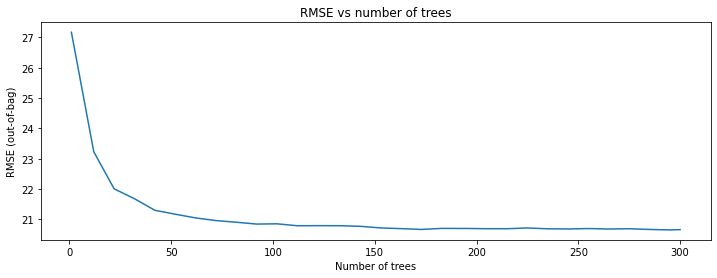

In [19]:
# plot the RMSE during training 
logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.title("RMSE vs number of trees")

plt.show()

## Bonus

### Train the same model, but restrict the max_depth to 3

In [20]:
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, max_depth=3)
model_rf.compile(metrics=["mse"])
model_rf.fit(x=train_ds)

tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=3)

12/12 [==============================] - 0s 3ms/step


In [23]:
# compare the score obtained in the evaluate method to the one calculated manually
mean_squared_error(X_test["attack"], model_rf.predict(test_ds))

538.7659840443899

In [24]:
# see all the available models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel]